In [1]:
from typing import Union
from enum import Enum, unique

import pandas as pd
import os
import time

import urllib
import requests
import ssl
import certifi

from random import randint

from datetime import datetime
from pytz import timezone

import threading
import IPython

# Used for debugging; pretty print JSON strings
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if not os.path.exists('/content/drive/MyDrive/'):
    raise Exception("Error: Mount Google Drive before continuing!")

BASE_DIR = '/content/drive/MyDrive/Data Science for Social Good - Spring 2022/data/'

# Define directory that contains intermediate SSL certificates
CERT_DIR = BASE_DIR + 'certificates/'

# Define directories to save data
SCRAPE_DIR = BASE_DIR + 'scraped_files/'
DATA_DIR = SCRAPE_DIR + 'DATA/'

current_date = datetime.now(timezone('US/Eastern')).strftime("%m-%d-%Y")

# Create all directories on the given paths if needed
os.makedirs(DATA_DIR + current_date, exist_ok=True)
print("Date used for scraping:", current_date)

Date used for scraping: 03-05-2022


# Helper Functions and Classes

In [4]:
@unique
class TownWithCaptcha(Enum):
    DESOTO = 'DeSoto'
    FORREST = 'Forrest'
    HANCOCK = 'Hancock'
    HARRISON = 'Harrison'
    LAMAR = 'Lamar'
    MARION = 'Marion'
    PERRY = 'Perry'
    YAZOO = 'Yazoo'

    # Return Name, rather than TownWithCaptcha.Name
    def __str__(self):
        return self.name


@unique
class TownWithoutCaptcha(Enum):
    PEARL_RIVER = 'PearlRiver'
    CLAY = 'Clay'
    ADAMS = 'Adams'
    HINDS = 'Hinds'
    JACKSON = 'Jackson'
    JONES = 'Jones'
    KEMPER = 'Kemper'
    MADISON = 'Madison'
    TUNICA = 'Tunica'

    # Return Name, rather than TownWithoutCaptcha.Name
    def __str__(self):
        return self.name


# Define a custom type to pass into functions
Town = Union[TownWithCaptcha, TownWithoutCaptcha]

def get_town_filename(town: Town) -> str:
    return f'{str(current_date)}_{town.value}.csv'

In [5]:
jail_captcha_links = {
    TownWithCaptcha.DESOTO: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/DeSoto_County_MS/',
    TownWithCaptcha.FORREST: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Forrest_County_MS/',
    TownWithCaptcha.HANCOCK: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HANCOCK_COUNTY_MS/',
    TownWithCaptcha.HARRISON: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HARRISON_COUNTY_JAIL_MS/',
    TownWithCaptcha.LAMAR: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Lamar_County_MS/',
    TownWithCaptcha.MARION: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Marion_County_MS/',
    TownWithCaptcha.PERRY: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Perry_County_MS/',
    TownWithCaptcha.YAZOO: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Yazoo_County_MS/',
}

In [6]:
def read_url(request: Union[str, urllib.request.Request]) -> str:
    NUM_SECONDS_TIMEOUT = 10

    ctx = ssl.create_default_context(ssl.Purpose.CLIENT_AUTH, cafile=certifi.where())
    response = urllib.request.urlopen(request, timeout=NUM_SECONDS_TIMEOUT, context=ctx)
    data = response.read()
    response.close()
    return data


def request_url(request: str, town: Town) -> Union[str, None]:
    if town in {TownWithoutCaptcha.ADAMS, TownWithoutCaptcha.MADISON}:
        user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
        headers = {'User-Agent': user_agent}
        request = urllib.request.Request(request, headers=headers)

    # Try the connection until success or NUM_ATTEMPTS is exceeded
    NUM_ATTEMPTS = 4
    for _ in range(NUM_ATTEMPTS):
        try:
            return read_url(request)
        except urllib.error.URLError as str_error:
            time.sleep(0.5)
            print("Exception:", town, str_error)

    print("Request failed for", town)
    return None

# Towns with Captchas Scraper

---



In [7]:
def town_with_captcha_scraper(town: TownWithCaptcha, captcha_key: str):
    jail_url = jail_captcha_links[town]
    jail_record_data = requests.post(
        jail_url,
        json={'captchaKey': captcha_key}
    )
    jail_record_data_json = jail_record_data.json()
    offender_view_key = jail_record_data_json['offenderViewKey']
    num_offenders = len(jail_record_data_json['offenders'])
    print(town, "Number of offenders:", num_offenders)

    def get_inmate_url(arrest_num: str):
        def gen_random_num_with_n_digits(n: int):
            """Based on:
            https://stackoverflow.com/a/2673399
            """
            range_start = 10 ** (n - 1)
            range_end = (10 ** n) - 1
            return randint(range_start, range_end)

        # Apparently the offender view key is just a random number (and the length doesn't matter)?
        # We need an offender view key to make our request
        # We use the default length that the website uses, which is 9
        LEN_VIEW_KEY = 9
        random_offender_view_key = gen_random_num_with_n_digits(LEN_VIEW_KEY)
        return f'{jail_url}{arrest_num}/offenderbucket/{random_offender_view_key}'

    offender_data = []
    cur_num_processed = 0
    for offender in jail_record_data_json['offenders']:
        arrest_num = offender['arrestNo']
        inmate_url = get_inmate_url(arrest_num)
        inmate_data = requests.post(
            inmate_url,
            json={'captchaKey': captcha_key}
        )
        inmate_data_json = inmate_data.json()

        # Add basic data
        row = {}
        row['Arrest Number'] = arrest_num
        row['Cases'] = inmate_data_json['cases']
        row['Charges'] = inmate_data_json['charges']

        # Add special fields
        for field in inmate_data_json['offenderSpecialFields']:
            field_name = field['labelText'].strip(':')
            row[field_name] = field['offenderValue']

        offender_data.append(row)
        cur_num_processed += 1
        if cur_num_processed % 50 == 0:
            print(town, "Processed", cur_num_processed)

    df = pd.DataFrame(offender_data)

    filename = get_town_filename(town)
    df.to_csv(f'{DATA_DIR}{current_date}/{filename}')

# Main Web Scraper

---



In [8]:
class WebScraperThread(threading.Thread):
    def __init__(self, thread_id: int, town: Town, captcha_key: str):
        threading.Thread.__init__(self)
        self.thread_id = thread_id
        self.town = town
        self.captcha_key = captcha_key

    def run(self):
        print("Starting", self.town)

        if self.town in TownWithCaptcha:
            town_with_captcha_scraper(self.town, self.captcha_key)
        # elif self.town == TownWithoutCaptcha.PEARL_RIVER:
        #     pearl_river()
        # elif self.town == TownWithoutCaptcha.CLAY:
        #     clay()
        # elif self.town == TownWithoutCaptcha.ADAMS:
        #     adams()
        # elif self.town == TownWithoutCaptcha.HINDS:
        #     hinds()
        # elif self.town == TownWithoutCaptcha.JACKSON:
        #     jackson()
        # elif self.town == TownWithoutCaptcha.JONES:
        #     jones()
        # elif self.town == TownWithoutCaptcha.KEMPER:
        #     kemper()
        # elif self.town == TownWithoutCaptcha.MADISON:
        #     madison()
        # elif self.town == TownWithoutCaptcha.TUNICA:
        #     tunica()
        else:
            raise Exception("Town not found:", self.town)

        print("Exiting", self.town, end='\n\n')


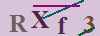

RXf3



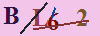

BL62



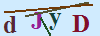

dJyD



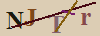

NJTr



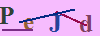

PeJd



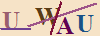

UWAU



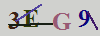

3EG9



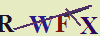

RWFX
StartingStartingStarting DESOTO
  FORREST
HANCOCK
Starting HARRISON
Starting LAMAR
Starting MARION
Starting PERRY
Starting YAZOO
LAMAR Number of offenders: 94
PERRY Number of offenders: 27
HANCOCK Number of offenders: 233
YAZOO Number of offenders: 262
FORREST Number of offenders: 289
DESOTO Number of offenders: 465
MARION Number of offenders: 255
HARRISON Number of offenders: 650
Exiting PERRY

HANCOCK Processed 50
FORREST Processed 50
DESOTO Processed 50
HARRISON Processed 50
MARION Processed 50
YAZOO Processed 50
LAMAR Processed 50
HANCOCK Processed 100
FORREST Processed 100
HARRISON Processed 100
DESOTO Processed 100
MARION Processed 100
YAZOO Processed 100
Exiting LAMAR

HANCOCK Processed 150
HARRISON Processed 150
MARION Processed 150
FORREST Processed 150
DESOTO Processed 150
YAZOO Processed 150
HANCOCK Processed 200
MARION Processed 200
HARRISON Processed 200
DESOTO Processed 200
FORREST Processed 200
YAZOO Processed 200
Exiting HANCOCK

MARION Processed 250
HARRISON Proce

In [9]:
threads = []
thread_id = 1

for town in TownWithCaptcha:
    is_captcha_matched = False
    while not is_captcha_matched:
        captcha_data = requests.get('https://omsweb.public-safety-cloud.com/jtclientweb/captcha/getnewcaptchaclient')
        image = captcha_data.json()['captchaImage']

        # # Save the image to a file
        # import base64
        # import matplotlib.pyplot as plt
        # img = image.split('base64,')[-1]
        # x = base64.decodebytes(img.encode('ascii'))
        # with open('captcha.jpg', 'wb') as f:
        #     f.write(x)

        html = f'<img src="{image}"/>'
        IPython.display.display(IPython.display.HTML(html))
        user_code = input()

        captcha_response_data = requests.post(
            'https://omsweb.public-safety-cloud.com/jtclientweb/Captcha/validatecaptcha',
            json={'userCode': user_code, 'captchaKey': captcha_data.json()['captchaKey']}
        )
        is_captcha_matched = captcha_response_data.json()['captchaMatched']

        if not is_captcha_matched:
            print("Incorrect captcha")

    thread = WebScraperThread(thread_id, town, captcha_response_data.json()['captchaKey'])
    threads.append(thread)
    thread_id += 1

for t in threads:
    t.start()

# Wait for all threads to complete
for t in threads:
    t.join()

print("Finished scraping")